In [1]:
#---------Importing libraries---------#




import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib_inline.backend_inline
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from matplotlib.colors import to_rgba
from torch import Tensor
from tqdm.notebook import tqdm  # Progress bar

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export

In [24]:
#ALTERNATIVE IMPORTINg
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.datasets
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
%matplotlib inline
from skimage import io
import splitfolders

## Data processing

In [3]:
#current folder
current_path = os.getcwd()
current_path

'c:\\Users\\Usuario\\1 notebooks\\apziva\\document flip classifier\\page-flip-detector\\notebooks'

In [4]:
#go to parent folder to see the project path
project_path = os.path.abspath(os.path.join(current_path, os.pardir))
project_path

'c:\\Users\\Usuario\\1 notebooks\\apziva\\document flip classifier\\page-flip-detector'

In [5]:
#set the data paths
DATA_DIR = os.path.join(project_path, 'data')
DATA_DIR_RAW = os.path.join(DATA_DIR, 'raw')
DATA_DIR_PROCESSED = os.path.join(DATA_DIR, 'processed')
DATA_DIR_RAW_IMG = os.path.join(DATA_DIR_RAW, 'images')
DATA_DIR_RAW_IMG_TRAIN = os.path.join(DATA_DIR_RAW_IMG, 'training')


In [6]:
#splting the data into train and validation, run only once!
#splitfolders.ratio(DATA_DIR_RAW_IMG_TRAIN, output=DATA_DIR_PROCESSED , ratio=(0.8, 0.2)) # take the images of the training folder and split them into train and validation folders

# Data augmentation

question: how to get the mean and std?

In [57]:
#creating transformation variables

train_transform = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    
])

val_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
    
])

test_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])



# Preparing data to train the model

In [58]:
#creating the datasets , with imagefolder to load the images even if they are in different folders.

train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(DATA_DIR_PROCESSED, 'train'),
                                                  transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(root=os.path.join(DATA_DIR_PROCESSED, 'val'),
                                                    transform=val_transform)
test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(DATA_DIR_RAW_IMG, 'testing'),
                                                    transform=test_transform)


In [59]:
#checking ou the classes and counts for each dataset

#training dataset
print('Train dataset classes: ', train_dataset.classes)
print('Train dataset classes labels: ', train_dataset.class_to_idx)
print('Train dataset classes counts: ', train_dataset.targets.count(0), train_dataset.targets.count(1))
print('Train dataset length: ', len(train_dataset))

print('\n----------------------------------\n')

#validation dataset
print('Validation dataset classes: ', val_dataset.classes)
print('Validation dataset classes labels: ', val_dataset.class_to_idx)
print('Validation dataset classes counts: ', val_dataset.targets.count(0), val_dataset.targets.count(1))
print('Validation dataset length: ', len(val_dataset))

print('\n----------------------------------\n')
#test dataset
print('Test dataset classes: ', test_dataset.classes)
print('Test dataset classes labels: ', test_dataset.class_to_idx)
print('Test dataset classes counts: ', test_dataset.targets.count(0), test_dataset.targets.count(1))
print('Test dataset length: ', len(test_dataset))

Train dataset classes:  ['flip', 'notflip']
Train dataset classes labels:  {'flip': 0, 'notflip': 1}
Train dataset classes counts:  929 984
Train dataset length:  1913

----------------------------------

Validation dataset classes:  ['flip', 'notflip']
Validation dataset classes labels:  {'flip': 0, 'notflip': 1}
Validation dataset classes counts:  233 246
Validation dataset length:  479

----------------------------------

Test dataset classes:  ['flip', 'notflip']
Test dataset classes labels:  {'flip': 0, 'notflip': 1}
Test dataset classes counts:  290 307
Test dataset length:  597


In [60]:
#creating our dataloader function

def get_data_loader(dataset, batch_size=16, shuffle=True):
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle)
    return data_loader

question: How to choose batch size?

In [61]:
#showing transformed images
def show_transformed_images(dataset):
    loader = get_data_loader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = make_grid(images, nrow=3) # nrow is the number of images displayed in a row
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0)) # permute to change the order of the channels from CxHxW to HxWxC
    plt.title('labels: {} \n where 0 is flipping and 1 is not fliping'.format(labels))
    plt.show()

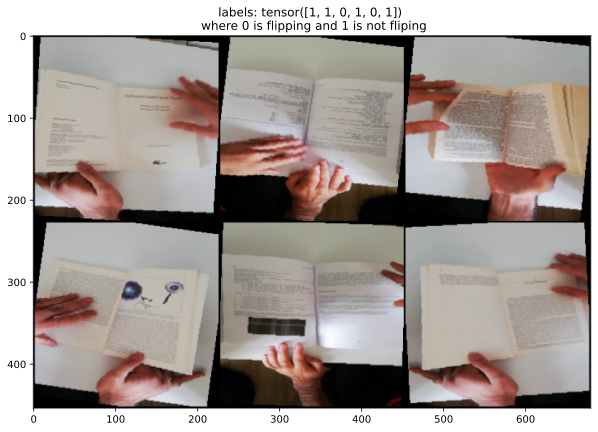

In [62]:
show_transformed_images(train_dataset)

In [63]:
#getting the dataloaders
train_loader = get_data_loader(train_dataset)
val_loader = get_data_loader(val_dataset, shuffle=False)
test_loader = get_data_loader(test_dataset, shuffle=False)

In [67]:
inputs, classes = next(iter(train_loader))

print(f'Batch size: {inputs.shape[0]}')
print(f'Number of color channels: {inputs.shape[1]}')
print(f'Image size: {inputs.shape[2]} x {inputs.shape[3]}')
print(f'Labels of the first batch: {classes}')

Batch size: 16
Number of color channels: 3
Image size: 224 x 224
Labels of the first batch: tensor([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


# Creating the model 

In [10]:
#creating a class to deal with the data

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.root_dir))
    
    def __getitem__(self, index):
        img_name = os.listdir(self.root_dir)[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = io.imread(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [11]:
print("Using torch", torch.__version__)

Using torch 2.1.0


In [12]:
torch.manual_seed(42)  # Setting the seed

In [13]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [14]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
if torch.cuda.is_available(): # GPU operations have a separate seed we also want to set
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False